# Example 2; Datasets and custom models

As the name suggests, this example is split into two parts.


* Deep dive into `System_data` and generation
  * Creating basic systems for data generation.
  * Combining multiple datasets
  * Downloading popular Datasets
  * MIMO 

* Estimation
  * Normalization.
  * creating your own SS_encoder_general system (grey box model)
  * .fit features
  * Memory Saving measures

# 1. Deep dive into `System_data`

## 1.1 Generating the data with deepSI

There are multiple `System` types which can be used to generate data. 

* `System` has `reset` to set the state and return the first measurement and `step` to increment the state and return the new measurement. 
* `System_ss` has `f` which advances the state, `h` which return the measurement and `reset` will set the state to zeros  default (can be overwritten).
* `System_deriv` has `derive` which return $\dot x$ and `h` which return the measurement and `reset` will set the state to zeros  default (can be overwritten).

This relays on [python inheritance](https://www.w3schools.com/python/python_inheritance.asp) of classes very heavily. 

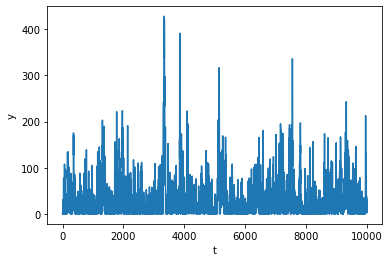

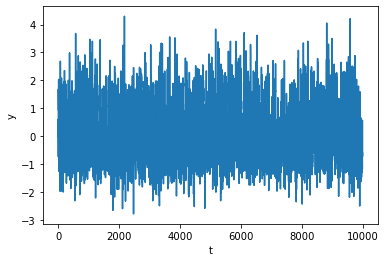

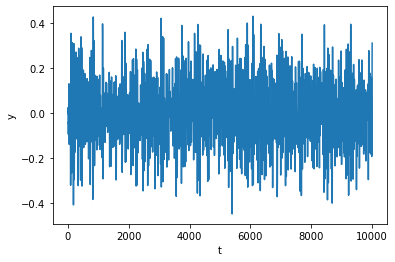

In [1]:
import deepSI
import numpy as np

from gym import spaces
class My_sys0(deepSI.System): #My_sys0 inherts from System
    def __init__(self):
        super(My_sys0,self).__init__()
    def reset_state(self):
        self.X = 0
    def measure_act(self,u):
        #updates state and return new observation
        y = self.X**2
        self.X = self.X*0.95 + u
        return y

sys = My_sys0()

N = 10_000
data = sys.apply_experiment(deepSI.System_data(u=np.random.normal(size=N)*1.5))
data.plot(show=True)


#state-space models
class My_sys1(deepSI.System_ss): #My_sys1 inherts from System_ss, System_ss inherts from System
    def __init__(self):
        super(My_sys1, self).__init__(nx=2, nu=None, ny=None)
    def f(self,x,u): #state function
        return x[0]/(1.2+x[1]**2)+x[1]*0.4, x[1]/(1.2+x[0]**2)+x[0]*0.4+u*(1+x[0]**2/10)
    def h(self,x,u): #output functions
        return x[1]*x[0]*0.1+x[0]

sys = My_sys1()
N = 10_000
data = sys.apply_experiment(deepSI.System_data(u=np.random.normal(size=N)*1.5))
data.plot(show=True) #plt.plot(data.y)

#state-space as ODE models
class My_sys2(deepSI.System_deriv): #My_sys2 inherets from System_deriv, System_deriv inherets from System_ss, System_ss inherets from System
    def __init__(self):
        super(My_sys2, self).__init__(nx=2, dt=0.1)
        
    def deriv(self,x,u):
        p,v = x
        dp = v
        dv = -5*p-p**3-v/2+u
        return [dp,dv]

    def h(self,x,u):
        return x[0]
    
sys = My_sys2()
data = sys.apply_experiment(deepSI.System_data(u=np.random.normal(size=N)))
data.plot(show=True)

## 1.2 Combining multiple separate datasets

A common thing is to have multiple independent measurement sequences. You don't want to concatenate these together because this will introduce transient errors. 

For this situation, one can use `System_data_list` which is a list of `system_data` with can directly be used in `.fit()` and has some additional functionality.

datasets= System_data_list with 20 series and total length 20000, nu=None, ny=None, normed=False lengths=[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000] dt=None
len(datasets)= 20


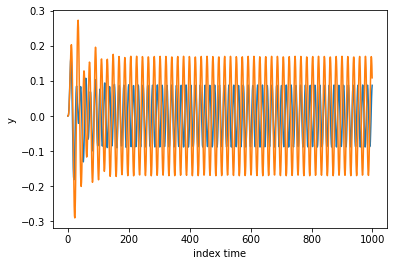

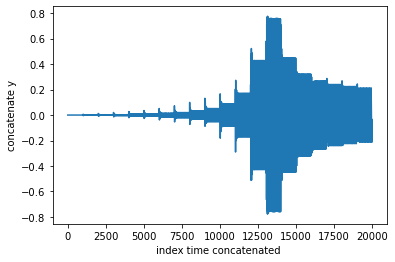

In [2]:
from deepSI import System_data, System_data_list
from matplotlib import pyplot as plt
sys = My_sys2()
datasets = System_data_list() #a custom list type
N = 1000
for tau in np.geomspace(2,100,num=20):
    exp = deepSI.System_data(u = np.sin(np.arange(N)/tau*2*np.pi))
    dataset = sys.apply_experiment(exp)
    datasets.append(dataset)
print('datasets=',datasets)
print('len(datasets)=',len(datasets)) #number of datsets
plt.plot(datasets[10].y) #indexing works as normal
plt.plot(datasets[11].y)
plt.xlabel('index time')
plt.ylabel('y')
plt.show()
plt.ylabel('concatenate y')
plt.xlabel('index time concatenated ')
plt.plot(datasets.y) #will concatenate all the y of all datasets, be carful when using this
plt.show()

NRMS sim linear 0.11228149583694529


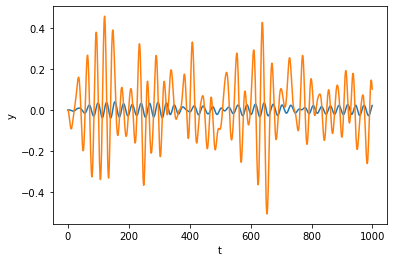

In [3]:
#create a test set.
exp = deepSI.System_data(u=deepSI.exp_design.filtered_signal(1000,fmax=0.1))
test = sys.apply_experiment(exp)

sys = deepSI.fit_systems.Sklearn_io_linear(2,2)
sys.fit(datasets) #use the multiple datasets

test_sim = sys.apply_experiment(test)
print('NRMS sim linear',test_sim.NRMS(test))
(test-test_sim).plot()
test.plot()

## 1.3 Downloading popular Datasets

* You can pull most datasets from https://www.nonlinearbenchmark.org/ and DaISy https://homes.esat.kuleuven.be/~tokka/daisydata.html
  * If some of these don't work feel free to contact me.
* They will be saved in a temp directory in `C:\Users\thisuser\AppData\Local\deepSI\data_sets/` (windows)
  * `deepSI.datasets.get_work_dirs()['data_sets']` will provide the directories


C:\Users\gerben\AppData\Local\deepSI/data_sets/
(re-)downloading dataset from ftp://ftp.esat.kuleuven.ac.be/pub/SISTA/data/mechanical/ballbeam.dat.gz 
 in C:\Users\gerben\AppData\Local\deepSI/data_sets/DaISy_data\ballbeam.dat.gz
extracting file...


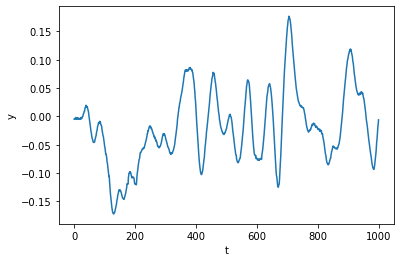

(re-)downloading dataset from https://data.4tu.nl/ndownloader/files/24686327 
 in C:\Users\gerben\AppData\Local\deepSI/data_sets/Cascaded_Tanks\CascadedTanksFiles.zip


100% |########################################################################|


extracting file...
System_data_list with 2 series and total length 2048, nu=None, ny=None, normed=False lengths=[1024, 1024] dt=None


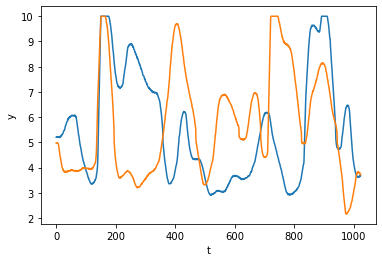

In [4]:
print(deepSI.datasets.get_work_dirs()['data_sets'])

ballbeam_data = deepSI.datasets.sista_database.ballbeam(dir_placement=None, #will download to Local folder
    force_download=True, # force the dataset to be (re-)downlaoded
    split_data=False, #automatic split the data into train and test. (Might not be optimal, check this!)
)
ballbeam_data.plot(show=True)

CTS_data = deepSI.datasets.Cascaded_Tanks(dir_placement=None, #will download to Local folder
    force_download=True, # force the dataset to be (re-)downlaoded
    split_data=False, #automatic split the data into train and test. (Might not be optimal, check this!)
)
print(CTS_data) #contais 2 datasets
train, test = CTS_data
train.plot()
test.plot()
plt.show()


## 1.4 Multiple inputs and Multiple outputs (MIMO) datasets

Some datasets have multiple input and multiple outputs which can be obtained by calling `ny` for the number of outputs and `nu` for the number of inputs. example;

In [5]:
sys_data = deepSI.datasets.CED(split_data=False) #SISO
print('######## CED ########')
print(sys_data)
print(f'u.shape={sys_data.u.shape}, nu={sys_data.nu}')
print(f'y.shape={sys_data.y.shape}, ny={sys_data.ny}')


sys_data = deepSI.datasets.sista_database.erie(split_data=False) #SISO
print('\n####### erie ########')
print(sys_data)
print(f'u.shape={sys_data.u.shape}, nu={sys_data.nu}')
print(f'y.shape={sys_data.y.shape}, ny={sys_data.ny}')

######## CED ########
System_data_list with 2 series and total length 1000, nu=None, ny=None, normed=False lengths=[500, 500] dt=None
u.shape=(1000,), nu=None
y.shape=(1000,), ny=None

####### erie ########
System_data of length: 57 nu=5 ny=2 normed=False dt=None
u.shape=(57, 5), nu=5
y.shape=(57, 2), ny=2


Note that `None` is used if the second dimention is absent. The full conversion list can be seen below:

```
y.shape = (Ntime,) -> ny = None
y.shape = (Ntime,1) -> ny = 1
y.shape = (Ntime,0) -> ny = 0 #zero is possible but not common
y.shape = (Ntime,123) -> ny = 123 #int
y.shape = (Ntime,3,3) -> ny = (3,3) #tuple
```

# 2 Custom Estimation

## 2.1 Normalization

When using neural networks `u` and `y` normalization is essential for good gradient propogation. This comes from the assumption made in [Xavier Weight initialization](https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) that both the input and the output are within normal range. 

For this reason all systems contain a `.norm` object which can be viewed and altered. This object will normalize the datasets when needed. 

In [6]:
sys = deepSI.fit_systems.SS_encoder()
print(sys.norm) #u0 is mean


train, test = deepSI.datasets.Silverbox()
sys.norm.fit(train) #initialize weights
print(sys.norm)

train_normed = sys.norm.transform(train)
print('original:')
print('u mean=',np.mean(train.u),'u std=',np.std(train.u))
print('y mean=',np.mean(train.y),'y std=',np.std(train.y))
print('Normalized:')
print('u mean=',np.mean(train_normed.u),'u std=',np.std(train_normed.u))
print('y mean=',np.mean(train_normed.y),'y std=',np.std(train_normed.y))



System_data_norm: (u0=0, ustd=1, y0=0, ystd=1)
System_data_norm: (u0=0.006142380733678717, ustd=0.02221031158562284, y0=0.0007860185372262015, ystd=0.054543655886918736)
original:
u mean= 0.006142380733678717 u std= 0.02221031158562184
y mean= 0.0007860185372262015 y std= 0.05454365588691774
Normalized:
u mean= -1.1139429935681383e-17 u std= 0.999999999999955
y mean= -1.594467422166159e-17 y std= 0.9999999999999817


This `.norm` will be fitted the first time that `.fit` (or `.init_model`) is called unless explicitly disabled by setting `auto_fit_norm=False`. example;

In [7]:

sys = deepSI.fit_systems.SS_encoder()
sys.norm.u0 = 10
sys.norm.ystd = 10
train, test = deepSI.datasets.Silverbox()
sys.fit(train, test, epochs=0, verbose=0)
print('1.',sys.norm) #altered
sys.fit(test, test, epochs=0, verbose=0)
print('1.1',sys.norm) #un-altered

sys = deepSI.fit_systems.SS_encoder()
sys.norm.u0 = 10
sys.norm.ystd = 10
train, test = deepSI.datasets.Silverbox()
sys.fit(train,test, epochs=0,verbose=0,auto_fit_norm=False)
print('2.',sys.norm) #un-altered



d:\drive\phd-ee-cs\deepsi\deepSI\fit_systems\fit_system.py:151: UserWarning: Fitting the norm due to auto_fit_norm=True
  warnings.warn('Fitting the norm due to auto_fit_norm=True')


1. System_data_norm: (u0=0.006142380733678717, ustd=0.02221031158562284, y0=0.0007860185372262015, ystd=0.054543655886918736)
1.1 System_data_norm: (u0=0.006142380733678717, ustd=0.02221031158562284, y0=0.0007860185372262015, ystd=0.054543655886918736)
2. System_data_norm: (u0=10, ustd=1, y0=0, ystd=10)


**Caution!** When a dataset is MIMO the normalization will be applied element-wise. This might be problematic when any output is always zero (or constant) for this will give divide by zero problems. 

In the MIMO case, I would recommend using your intuition what would be the most effective normalization and using `auto_fit_norm=False`.

System_data_norm: (u0=99.85399256358356, ustd=3.887966721490943, y0=[8.89121129e-02 4.41274567e+02], ystd=[0.01309719 3.06124072])


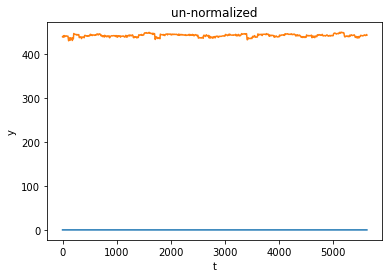

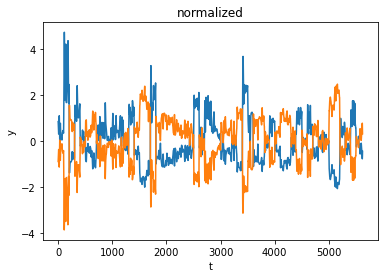

In [8]:
train, test = deepSI.datasets.sista_database.cstr() #MIMO (nu=None, ny=2)
sys = deepSI.fit_systems.SS_encoder()
sys.fit(train_sys_data=train,val_sys_data=test,epochs=0,verbose=0)
print(sys.norm) #element wise norm

plt.title('un-normalized')
train.plot()
plt.show()

plt.title('normalized')
train_normed = sys.norm.transform(train)
train_normed.plot() #manually use the norm
plt.show()

## 2.2 Creating your own encoder structure 

`SS_encoder` only implements feedforward neural networks, hence, `SS_encoder_general` is available where any part can be altered (its is a bit slower). 

Lets make a model with the following linear affine structure

$$
x_{k+1} = A x_k + B(x_k) u_k \\
y_k = C x_k
$$

In [12]:
from torch import nn
import deepSI
import numpy as np
import torch

class My_encoder_net(nn.Module): #a simple FC net with a residual (defaulth appraoch)
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(My_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod(self.ny,dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)

class My_state_net(nn.Module): #
    def __init__(self, nx, nu, nodes_per_layer=20):
        super(My_state_net, self).__init__()
        self.nu = nu
        self.nx = nx
        nu = 1 if nu==None else nu
        self.Apart = nn.Linear(nx, nx)
        self.Bpart =  nn.Sequential(nn.Linear(nx, nodes_per_layer), nn.Tanh(), nn.Linear(nodes_per_layer,nx*nu))

    def forward(self, x, u):
        #first dimention is always the batch dimention
        # x shape: (Nb, 1)
        # u shape: (Nb)
        if self.nu == None:
            u = u[:,None] #convert to (Nb,1) if needed
        Blin = self.Bpart(x) #returns shape: (Nb, nx*nu)
        Bmat = Blin.view(x.shape[0], self.nx, 1 if self.nu==None else nu) #reshape to (Nb, nx, nu)
        
        return self.Apart(x) + torch.einsum('bij,bj->bi', Bmat, u) #einstein summation notation

class My_output_net(nn.Module):
    def __init__(self, nx, ny):
        super(My_output_net, self).__init__()
        self.ny = ny
        self.Cpart = nn.Linear(nx, 1 if ny==None else ny)

    def forward(self, x ,u=None):
        #first dimention is always the batch dimention
        y = self.Cpart(x)
        if self.ny is None:
            return y[:,0]
        else:
            return y
    

In [13]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=2, na=5, nb=5, \
                                                e_net=My_encoder_net, e_net_kwargs=dict(n_nodes_per_layer=20),\
                                                f_net=My_state_net, f_net_kwargs=dict(nodes_per_layer=20),\
                                                h_net=My_output_net)

train, test = deepSI.datasets.Cascaded_Tanks()
fit_sys.fit(train, test, epochs=500, loss_kwargs=dict(nf=50))

Initilizing the model and optimizer
Size of the training array =  833.6 kB
N_training_samples = 970, batch_size = 256, N_batch_updates_per_epoch = 3
Initial Validation sim-NRMS= 1.760555287952329


  0%|          | 0/500 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 1.5481756996499767
Epoch    1, sqrt loss   1.561, Val sim-NRMS  1.548, Time Loss: 35.5%, data: 0.0%, val: 64.5%, 16.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 1.361506805465998
Epoch    2, sqrt loss   1.424, Val sim-NRMS  1.362, Time Loss: 34.9%, data: 0.0%, val: 65.1%, 16.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 1.2090727598599387
Epoch    3, sqrt loss   1.213, Val sim-NRMS  1.209, Time Loss: 34.8%, data: 0.2%, val: 65.0%, 17.2 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 1.0943887136599968
Epoch    4, sqrt loss   1.083, Val sim-NRMS  1.094, Time Loss: 34.8%, data: 0.1%, val: 65.1%, 17.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 1.0376985461175803
Epoch    5, sqrt loss   1.026, Val sim-NRMS  1.038, Time Loss: 34.6%, data: 0.2%, val: 65.1%, 17.4 batches/sec
#

########## New lowest validation loss achieved ########### sim-NRMS = 0.9552317129417199
Epoch   43, sqrt loss  0.8896, Val sim-NRMS 0.9552, Time Loss: 34.5%, data: 0.4%, val: 65.1%, 17.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.9538522450267999
Epoch   44, sqrt loss   0.887, Val sim-NRMS 0.9539, Time Loss: 34.5%, data: 0.4%, val: 65.1%, 17.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.9526458213905197
Epoch   45, sqrt loss  0.8769, Val sim-NRMS 0.9526, Time Loss: 34.5%, data: 0.4%, val: 65.1%, 17.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.9515277288489957
Epoch   46, sqrt loss  0.8858, Val sim-NRMS 0.9515, Time Loss: 34.5%, data: 0.4%, val: 65.1%, 17.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.9502795510781836
Epoch   47, sqrt loss  0.8787, Val sim-NRMS 0.9503, Time Loss: 34.5%, data: 0.4%, val: 65.1%, 17.5 batches/sec


########## New lowest validation loss achieved ########### sim-NRMS = 0.8970344108972643
Epoch   89, sqrt loss  0.7824, Val sim-NRMS  0.897, Time Loss: 34.3%, data: 0.4%, val: 65.2%, 17.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.8964571211910267
Epoch   90, sqrt loss  0.7702, Val sim-NRMS 0.8965, Time Loss: 34.3%, data: 0.4%, val: 65.2%, 17.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.8892748671073114
Epoch   91, sqrt loss  0.7683, Val sim-NRMS 0.8893, Time Loss: 34.3%, data: 0.4%, val: 65.2%, 17.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.8856243086628791
Epoch   92, sqrt loss  0.7583, Val sim-NRMS 0.8856, Time Loss: 34.3%, data: 0.4%, val: 65.2%, 17.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.8815024865177763
Epoch   93, sqrt loss  0.7519, Val sim-NRMS 0.8815, Time Loss: 34.3%, data: 0.4%, val: 65.2%, 17.6 batches/sec


Epoch  137, sqrt loss  0.2939, Val sim-NRMS 0.5118, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  138, sqrt loss  0.2922, Val sim-NRMS 0.5173, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  139, sqrt loss   0.288, Val sim-NRMS  0.522, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  140, sqrt loss  0.2899, Val sim-NRMS 0.5234, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  141, sqrt loss   0.287, Val sim-NRMS 0.5224, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  142, sqrt loss  0.2822, Val sim-NRMS 0.5162, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  143, sqrt loss   0.285, Val sim-NRMS 0.5167, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  144, sqrt loss  0.2791, Val sim-NRMS 0.5323, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
Epoch  145, sqrt loss  0.2842, Val sim-NRMS 0.5213, Time Loss: 34.5%, data: 0.5%, val: 65.0%, 17.5 batches/sec
E

Epoch  212, sqrt loss  0.2533, Val sim-NRMS 0.5944, Time Loss: 34.9%, data: 0.6%, val: 64.5%, 17.3 batches/sec
Epoch  213, sqrt loss  0.2433, Val sim-NRMS 0.5847, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
Epoch  214, sqrt loss  0.2496, Val sim-NRMS 0.5985, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
Epoch  215, sqrt loss  0.2511, Val sim-NRMS 0.6197, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
Epoch  216, sqrt loss   0.251, Val sim-NRMS 0.5827, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
Epoch  217, sqrt loss   0.244, Val sim-NRMS 0.6094, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
Epoch  218, sqrt loss  0.2482, Val sim-NRMS 0.6184, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
Epoch  219, sqrt loss  0.2488, Val sim-NRMS  0.643, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
Epoch  220, sqrt loss  0.2524, Val sim-NRMS 0.6376, Time Loss: 35.0%, data: 0.6%, val: 64.4%, 17.2 batches/sec
E

Epoch  287, sqrt loss  0.2456, Val sim-NRMS 0.5525, Time Loss: 35.1%, data: 0.7%, val: 64.2%, 17.0 batches/sec
Epoch  288, sqrt loss  0.2428, Val sim-NRMS 0.5466, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
Epoch  289, sqrt loss  0.2364, Val sim-NRMS 0.5875, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
Epoch  290, sqrt loss  0.2308, Val sim-NRMS 0.5823, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
Epoch  291, sqrt loss    0.24, Val sim-NRMS 0.5897, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
Epoch  292, sqrt loss    0.24, Val sim-NRMS 0.5775, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
Epoch  293, sqrt loss  0.2456, Val sim-NRMS  0.581, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
Epoch  294, sqrt loss  0.2319, Val sim-NRMS 0.5263, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
Epoch  295, sqrt loss  0.2441, Val sim-NRMS 0.5378, Time Loss: 35.2%, data: 0.7%, val: 64.1%, 17.0 batches/sec
E

Epoch  360, sqrt loss  0.2362, Val sim-NRMS 0.5076, Time Loss: 35.1%, data: 0.6%, val: 64.2%, 17.1 batches/sec
Epoch  361, sqrt loss  0.2373, Val sim-NRMS 0.5167, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
Epoch  362, sqrt loss  0.2351, Val sim-NRMS 0.5313, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
Epoch  363, sqrt loss  0.2359, Val sim-NRMS 0.5315, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
Epoch  364, sqrt loss  0.2333, Val sim-NRMS 0.5333, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
Epoch  365, sqrt loss  0.2368, Val sim-NRMS 0.5312, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
Epoch  366, sqrt loss  0.2381, Val sim-NRMS 0.5348, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
Epoch  367, sqrt loss  0.2425, Val sim-NRMS 0.5958, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
Epoch  368, sqrt loss  0.2386, Val sim-NRMS  0.518, Time Loss: 35.1%, data: 0.6%, val: 64.3%, 17.1 batches/sec
E

Epoch  435, sqrt loss  0.3008, Val sim-NRMS 0.5618, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.2 batches/sec
Epoch  436, sqrt loss  0.2943, Val sim-NRMS  0.557, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.2 batches/sec
Epoch  437, sqrt loss  0.2897, Val sim-NRMS 0.5434, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.2 batches/sec
Epoch  438, sqrt loss  0.2837, Val sim-NRMS 0.5367, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.2 batches/sec
Epoch  439, sqrt loss  0.2822, Val sim-NRMS 0.5384, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.3 batches/sec
Epoch  440, sqrt loss  0.2805, Val sim-NRMS  0.548, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.3 batches/sec
Epoch  441, sqrt loss  0.2796, Val sim-NRMS 0.5569, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.3 batches/sec
Epoch  442, sqrt loss  0.2777, Val sim-NRMS 0.5635, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.3 batches/sec
Epoch  443, sqrt loss  0.2743, Val sim-NRMS 0.5777, Time Loss: 35.0%, data: 0.6%, val: 64.3%, 17.3 batches/sec
E

## 2.3 Testing models

If you want to develop a model then I recommend testing each component before using `.fit`. This will save you quite some time in the long run. 

Testing can be done with the following commands; Also see `Encoder-grey-box-approach-alpha.ipynb`

In [14]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=2, na=5, nb=5, \
                                                e_net=My_encoder_net, e_net_kwargs=dict(n_nodes_per_layer=20),\
                                                f_net=My_state_net, f_net_kwargs=dict(nodes_per_layer=20),\
                                                h_net=My_output_net)
print("before init_nets hasattr(fit_sys,'fn') =",hasattr(fit_sys,'fn')) #fn, hn and encoder doesn't exist at this point 
#This is because fn hn and encoder structure are depedent on nu and ny.
#So we need to give some additional information with on additional command. 
fit_sys.init_model(train) #returns all the paramters
print("after  init_nets hasattr(fit_sys,'fn') =",hasattr(fit_sys,'fn')) #fn, hn and encoder doesn't exist at this point 
Nb = 3 #batch size
xnow = torch.randn(Nb,fit_sys.nx)
unow = torch.randn(Nb)
xout = fit_sys.fn(xnow,unow) #(x.shape=(Nb, nx) ,u= (Nb,nu) or (Nb,))
print('xout:',xout)

yout = fit_sys.hn(xnow) #(x.shape=(Nb, nx) ,u= (Nb,nu) or (Nb,))
print('yout:',yout)

upast = torch.randn(Nb, fit_sys.nb)
ypast = torch.randn(Nb, fit_sys.na)
xinit = fit_sys.encoder(upast, ypast)
print('xinit:',xinit)

#you can also get the parameters like:
print('fit_sys.fn.Apart.weight=',fit_sys.fn.Apart.weight)
print('fit_sys.fn.Apart.bias=',fit_sys.fn.Apart.bias)

before init_nets hasattr(fit_sys,'fn') = False
after  init_nets hasattr(fit_sys,'fn') = True
xout: tensor([[-1.7332,  0.5848],
        [-0.1298,  0.5423],
        [-1.4617,  1.1308]], grad_fn=<AddBackward0>)
yout: tensor([ 0.7258, -0.3825,  0.2680], grad_fn=<SelectBackward>)
xinit: tensor([[-0.2178,  0.0760],
        [ 0.2967,  0.1570],
        [ 0.4555,  0.0837]], grad_fn=<AddBackward0>)
fit_sys.fn.Apart.weight= Parameter containing:
tensor([[ 0.3574,  0.4472],
        [ 0.1525, -0.0975]], requires_grad=True)
fit_sys.fn.Apart.bias= Parameter containing:
tensor([-0.6913,  0.4295], requires_grad=True)


## 2.4 .fit features

the .fit function on SS encoder function has many useful arguments. (docs: https://deepsi.readthedocs.io/en/latest/fit_systems.html#deepSI.fit_systems.System_torch.fit)

### 2.4.1 `loss_kwargs`

All the key word arguments (`dict`) passed to the loss function `.loss` and the training array creator `.make_training_data`. Some common ones are;

* `nf` [int], the length of the subsections
* `online_construct` [boole], that the training arrays will be built in an online manner, can save up to 100 times memory but can be quite a bit slower. 


### 2.4.2 `optimizer_kwargs`

All the arguments will be passed to `init_optimizer`. 

* `'optimizer'` will be the optimizer function itself. (like, `torch.optim.adam` (which is default))
* `'lr'` which will be passed to  `'optimizer'`  and is the optimizer. 
* `'parameters_optimizer_kwargs'` the per element learning parameters by {'name':{'lr':1e-3}, 'name2':{'lr':5e-3}}

note that the optimizer is initialised only for the first call of `.fit`. Afterwards, this argument is ignored. 

### 2.4.3 `concurrent_val`

concurrent_val [boole] will change the validation process from ones after each epoch to concurrently with the training process. This can be quite a bit faster if the validation set is very large.

### 2.4.4 `cuda`

**Caution!** This can be quite unstable so use with caution.

[boole] will enable GPU (Cuda) training which can be faster if the network is large enough or it has parallel components (CNN).

### 2.4.5 `validation_measure`

Specify which measure should be used for validation, e.g. `'sim-RMS'`, `'sim-NRMS_mean_channel'`, `'sim-NRMS_sys_norm'`, ect. See `.cal_validation_error` for details.